# Traitement des données des simulations

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import scipy
from scipy import signal
import sympy as sy
from IPython.display import display
from scipy.io.wavfile import write as wavWrite
import h5py
import ast
import os
import sys
import shutil
sy.init_printing()
#import tikzplotlib

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Settings pour les figures matplotlib
mpl.rcParams['figure.dpi'] = 72

#%matplotlib nbagg

FIGSIZE  = (10,5)
FONTSIZE = 30
TICK_FONTSIZE = 24
LEGEND_FONTSIZE = 22

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.rc('text', usetex=True)
LATEX_FIG_PATH = "../01_FIGS/"
FIGS_PATH      = "02_figs/"
PPTY_XVBAR = {'c':  'r', 
              'linestyle':'-.', 
              'linewidth':2,
             }
PPTY_LEG = { 'fontsize' : 16,
             'loc'      : 'upper left',
           }

In [3]:
fmt = lambda s: r'%s_{%s}' % (s.split('_', 1)[0], s.split('_', 1)[1].replace('_', ''))

def export2tikzpdf(path, name):
    """ Exporte la figure courante dans un nouveau dossier,
    en y ajoutant un numéro unique, ordre croissant
    @args: path: chemin vers le dossier d'export
    @args: name: nom du dossier 
    """
    # Liste des dossier dans le path    
    list_dir = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        list_dir.extend(dirnames)
        break
        
        
    # Dans le cas où la liste de dossier est vide
    if not list_dir:
        list_dir.append(str(0))
    
    # Nombre le plus grand?
    for i in range(len(list_dir)):
        list_dir[i] = int(list_dir[i][0:2])
        
    # rajoute un zéro au debut si < 10 (formattage)
    new_fig_number = str(max(list_dir) + 1).zfill(2)

    full_path_new_dir = os.path.join(path, 
                                     str(new_fig_number) + '_' + name)
    
    # Création du nouveau dossier
    os.mkdir(full_path_new_dir)
    
    # Copie des fichiers de makefile + conteneur latex
    src_files = ['fig_main.tex', 'makefile']
    dst_files = ['','']
    for i in range(len(src_files)):
        dst_files[i] = os.path.join(full_path_new_dir, src_files[i])
        src_files[i] = os.path.join(path, src_files[i])
        shutil.copyfile(src_files[i], dst_files[i])

    # generation du fichier tikz
    tikz_file_path = os.path.join(full_path_new_dir,"fig.tex")
    tikzplotlib.save(tikz_file_path)
    
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()

### Chargement des données

In [4]:
#%% Loading dataset
%store -r filename 
filename = '03_data/simu.04_03.09_35.h5'
print(filename)

fid = h5py.File(filename, 'r')
fid.flush()

metadata = fid["metadata"]
data     = fid["data_simu"]
model    = fid["model"]

date_now = metadata["date_now"][:]
config = ast.literal_eval(str(metadata["config"][0]))
print(*date_now)

03_data/simu.04_03.09_35.h5
4 3 9 35


In [5]:
SAVE_FIG = True
if SAVE_FIG:
    FOLDER_PATH = FIGS_PATH + "simu_{0}_{1}.{2}_{3}".format(*(str(val).zfill(2) for val in date_now))
    os.mkdir(FOLDER_PATH)

In [6]:
t = data["t"][:]
tmax = max(t)

indt = (t <= tmax) * (t >= 0.)

N_ports, Nx, NW = model["Nu"][0], model["Nx"][0], model["Nw"][0]

In [7]:
#xbar = [t[300],]
xbar = []

In [8]:
config

{'fs': 100000.0,
 'path': '/home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data',
 'lang': 'c++',
 'cmake': 'cmake',
 'grad': 'discret',
 'maxit': 20,
 'pbar': False,
 'split': False,
 'timer': True,
 'epsdg': 5.477420592293901e-07,
 'eps': 2.220446049250313e-16}

In [9]:
volume_refs = [model["VT_subs"]["V_01"][()], model["VT_subs"]["V_02"][()]]
rho_refs    = [model["VT_subs"]["rho_0"][()], model["VT_subs"]["rho_0"][()]]

In [10]:
# On récupère les VT_subs
params_label = list(model["VT_subs"].keys())
ell_1 = model["VT_subs"]["ell_1"][()]

for label in params_label:
    value = model["VT_subs"][label][()]
    exec("%s = %f" % (label, value))
    print("%s = %f" % (label, value))

L_1 = 0.020000
L_2 = 0.060000
P_atm = 101325.000000
V_01 = 0.000035
V_02 = 0.000315
Z_ray = 2222.222222
ell_1 = 0.043750
ell_2 = 0.043750
gamma = 1.400000
h_01 = 0.020000
h_02 = 0.060000
rho_0 = 1.225000


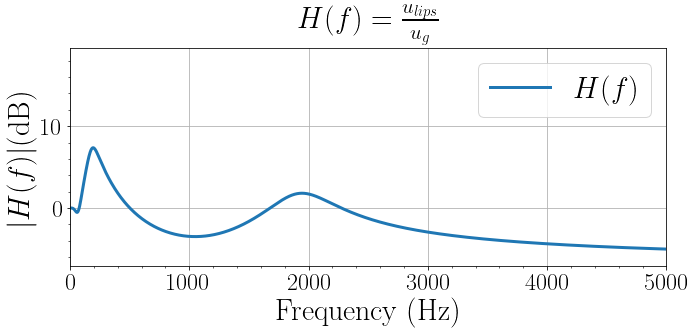

In [11]:
#%matplotlib nbagg
q_glotte  = np.divide(data['dxH'][:,0], data['x'][:,7]+rho_refs[0])
q_levres  = np.divide(data['w'][:,2], data['x'][:,8]+rho_refs[0])

#sos = signal.butter(200, 10, 'hp', fs=config['fs'], output='sos')
#q_glotte = signal.sosfilt(sos, q_glotte)
#q_levres = signal.sosfilt(sos, q_levres)

len_sig   = len(q_glotte)
fs        = config["fs"]

freq_max  = fs/2
Nfft      = int(next_power_of_2(len_sig))
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hann', len_sig)
#win       = signal.kaiser(len_sig, beta=14)

fft_qout = np.fft.fft(q_levres*win, Nfft)
fft_qin = np.fft.fft(q_glotte*win, Nfft)
fft_H_shift = np.fft.fftshift(np.divide(fft_qout, fft_qin))

############
## FIGURE ##
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()



plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])), linewidth=3)
#plt.loglog(freq_vec[indf], np.abs(fft_H_shift[indf]))
plt.xlabel('Frequency (Hz)', fontsize=FONTSIZE)
plt.ylabel('$|H(f)|$(dB)', fontsize=FONTSIZE)



plt.xlim([0, 5000])
plt.title(r'$H(f)=\frac{u_{lips}}{u_{g}}$', fontsize=FONTSIZE)
plt.grid()

plt.legend([r'$H(f)$'],
           fontsize=FONTSIZE, loc='upper right')


freqs = []
i = 0
for freq in freqs:
    i = i+1
    ax.axvline(x=freq, **PPTY_XVBAR)
    ann = plt.annotate(r"$f_{0} = {1}$ Hz".format(i,freq), 
                       (freq-30, 10),
                       bbox=dict(boxstyle='Round', fc='white', ec='k', pad=0.4),
                       fontsize=20)

    
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.minorticks_on()


plt.tight_layout()
if False:
    title = "repr_freq_uL_vers_uR"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

--------------
## Entrées

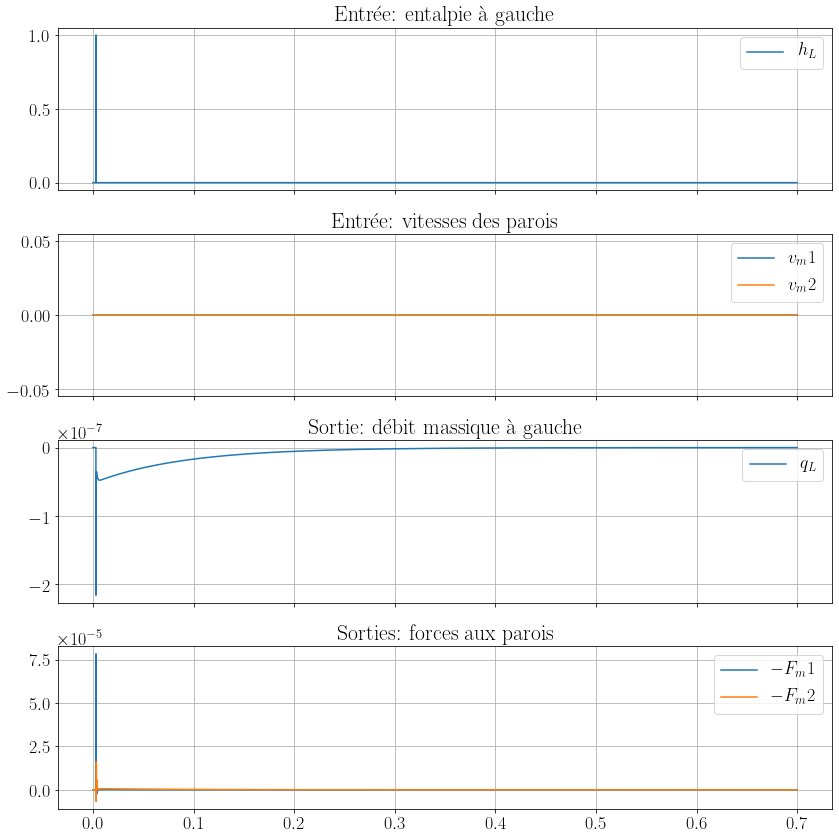

In [12]:
#%matplotlib nbagg
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

## Entrées
ax = axs[0]
label = r'$%s$' % (model["u_label"][0])
ax.plot(t[indt], data["u"][indt,0], label=label)
ax.set_title('Entrée: entalpie à gauche')
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

# Vitesses
ax = axs[1]
for i in range(1,N_ports):
    label = r'$%s$' % (model["u_label"][i])
    ax.plot(t[indt], data["u"][indt,i], label=label)
ax.set_title('Entrée: vitesses des parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

## Sorties: Forces

ax = axs[2]
label = r'$%s$' % (model["y_label"][0])
ax.plot(t[indt], data["y"][indt,0], label=label)
ax.set_title('Sortie: débit massique à gauche')

ax = axs[3]
for i in range(1, N_ports):
    label = r'$%s$' % (model["y_label"][i])
    ax.plot(t[indt], data["y"][indt,i], label=label)
ax.set_title('Sorties: forces aux parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)


for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

for ax in axs.ravel():
    ax.legend(frameon=True, loc="upper right")
    ax.grid()

plt.tight_layout()
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
    
if SAVE_FIG:
    title = "input_output"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

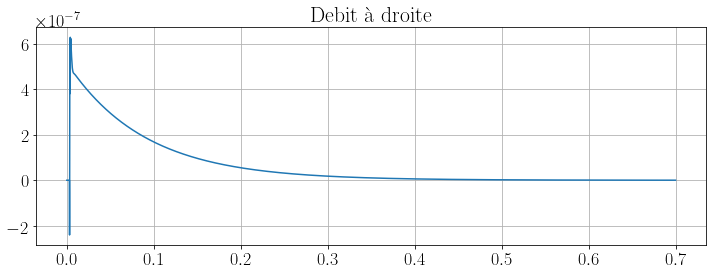

In [13]:
plt.figure(figsize=(12,4))
plt.plot(t[indt], data["x"][indt,2])
plt.title('Debit à droite')
plt.grid()

----------
## Bilan de puissance et ports

In [14]:
# Calcule du bilan de puissance
N_diss = len(model["w_label"][:])
Pdiss = np.prod([data["w"][:,0],data["z"][:,0]], axis=0)
for i in range(1, N_diss):
    prod = np.prod([data["w"][:,i],data["z"][:,i]], axis=0)
    Pdiss = np.add(Pdiss, prod)

Pext = np.prod([data["u"][:,0],data["y"][:,0]], axis=0)
for i in range(1, N_ports):
    prod = np.prod([data["u"][:,i],data["y"][:,i]], axis=0)
    Pext = np.add(Pext, prod)

dEdt = np.prod([data["dxH"][:,0],data["dtx"][:,0]], axis=0)
for i in range(1,Nx):
    prod = np.prod([data["dxH"][:,i],data["dtx"][:,i]], axis=0)
    dEdt = np.add(dEdt, prod)

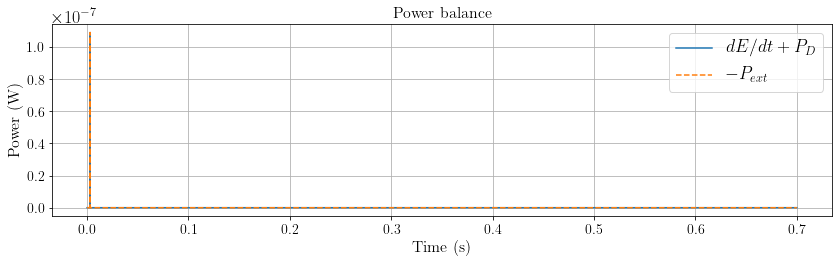

In [15]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (Pdiss + dEdt)[indt])
ax.plot(t[indt], (-Pext)[indt], '--')
ax.set_title(r'Power balance', fontsize=16)
ax.grid()

ax.legend([r'$dE/dt + P_D$', '$-P_{ext}$'], loc="upper right")
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()


if SAVE_FIG:
    title = "power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

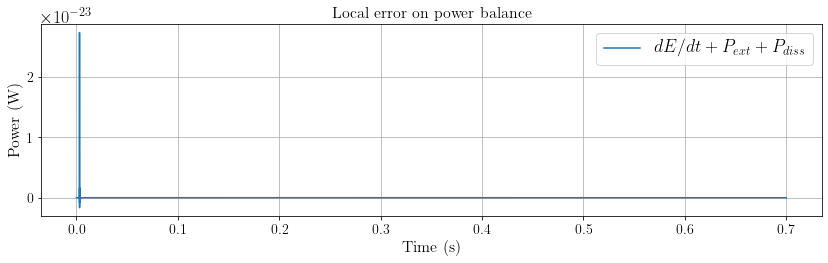

In [16]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (dEdt+Pext+Pdiss)[indt])
ax.set_title(r'Local error on power balance', fontsize=16)
ax.grid()

ax.legend([r'$dE/dt+P_{ext}+P_{diss}$'], loc="upper right")
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()

if SAVE_FIG:
    title = "error_on_power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

--------------
## Vue d'ensemble

In [17]:
print(model["y_label"][:])
print(model["w_label"][:])

['q_L' '-F_m1' '-F_m2']
['v_k1' 'v_k2' 'q']


In [18]:
rho_refs[0]

---
## Fonction de transfert débit glottique vers débit aux lèvres

Length of signal: 70000
131072


<IPython.core.display.Javascript object>


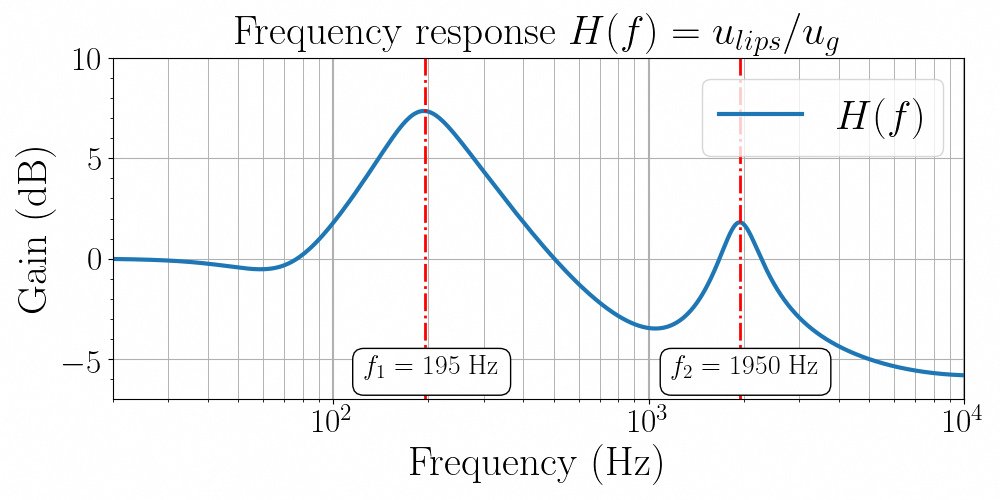

In [31]:
%matplotlib nbagg
q_glotte  = np.divide(data['dxH'][:,0], data['x'][:,7]+rho_refs[0])
q_levres  = np.divide(data['w'][:,2], data['x'][:,8]+rho_refs[0])

len_sig   = len(q_glotte)
print("Length of signal: {0}".format(len_sig))
fs        = config["fs"]

freq_max  = fs/2
Nfft      = int(next_power_of_2(len_sig))
print(Nfft)
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hann', len_sig)

fft_qout = np.fft.fft(q_levres*win, Nfft)
fft_qin = np.fft.fft(q_glotte*win, Nfft)
fft_H_shift = np.fft.fftshift(np.divide(fft_qout, fft_qin))

############
## FIGURE ##
fig = plt.figure(figsize=FIGSIZE)
ax = plt.gca()



#plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])), linewidth=3)
plt.semilogx(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])), linewidth=3)
#plt.loglog(freq_vec[indf], np.abs(fft_H_shift[indf]))
plt.xlabel('Frequency (Hz)', fontsize=FONTSIZE)
plt.ylabel('Gain (dB)', fontsize=FONTSIZE)



#plt.xlim([20, 10000])
#plt.ylim([-6, 11])

plt.xlim([20, 10000])
plt.ylim([-7, 10])
#plt.title(r'$H(f)=\frac{u_{lips}}{u_{g}}$', fontsize=FONTSIZE)
plt.title(r'Frequency response $H(f)=u_{lips}/u_{g}$', fontsize=FONTSIZE)
plt.grid()

plt.legend([r'$H(f)$'],
           fontsize=FONTSIZE, loc='upper right')


freq = 195
ax.axvline(x=freq, **PPTY_XVBAR)
ann = plt.annotate(r"$f_{0} = {1}$ Hz".format(1,freq), 
                       (freq-70, -6),
                       bbox=dict(boxstyle='Round', fc='white', ec='k', pad=0.4),
                       fontsize=20)


freq = 1950
ax.axvline(x=freq, **PPTY_XVBAR)
ann = plt.annotate(r"$f_{0} = {1}$ Hz".format(2,freq), 
                       (freq-770, -6),
                       bbox=dict(boxstyle='Round', fc='white', ec='k', pad=0.4),
                       fontsize=20)

    
ax = plt.gca()
ax.grid(which='minor', linewidth=0.7, axis='x', alpha=0.3, color='k')
ax.grid(which='major', linewidth=1.5, axis='x')
ax.tick_params(labelsize=TICK_FONTSIZE)
ax.minorticks_on()
plt.tight_layout()

if SAVE_FIG:
    title = "repr_freq_uL_vers_uR"
    tmp_path = os.path.join(FOLDER_PATH,title)
    #plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

In [ ]:
plt.figure(figsize=FIGSIZE)
#plt.plot(data['dxH'][:,2])
#plt.plot(data['x'][:,7]+rho_refs[0])
plt.plot(np.divide(data['w'][:,2], data['x'][:,8]+rho_refs[0]))
plt.plot(np.divide(data['dxH'][:,0], data['x'][:,7]+rho_refs[0]))
#plt.plot(np.divide(q_glotte,np.divide(data['dxH'][:,0], data['x'][:,7]+rho_refs[0])))
#plt.plot(q_glotte)